In [6]:
options(warn=-1)
suppressWarnings({
    libs <- c("tidyverse","gridExtra","estimatr")
load.libs <- function(x){
  for(i in x){
    if(!require(i,character.only = TRUE )){
      install.packages(i,dependencies = TRUE )
      library(i,character.only = TRUE )
    }
  }
}
load.libs(libs)
})

In [1]:
data_preprocessed = read.csv("data_preprocessed.csv", header = T)
data = data_preprocessed
head(data)

MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,MiscVal,MoSold,YrSold,SaleType,SaleCondition,log_price,Age,HasBasement,HasGarage,HasFireplace
60,RL,65,9.042040,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,2,2008,WD,Normal,12.24770,5,Yes,Yes,No
20,RL,80,9.169623,Pave,Reg,Lvl,AllPub,FR2,Gtl,...,0,5,2007,WD,Normal,12.10902,31,Yes,Yes,Yes
60,RL,68,9.328212,Pave,IR1,Lvl,AllPub,Inside,Gtl,...,0,9,2008,WD,Normal,12.31717,7,Yes,Yes,Yes
70,RL,60,9.164401,Pave,IR1,Lvl,AllPub,Corner,Gtl,...,0,2,2006,WD,Abnorml,11.84940,91,Yes,Yes,Yes
60,RL,84,9.565284,Pave,IR1,Lvl,AllPub,FR2,Gtl,...,0,12,2008,WD,Normal,12.42922,8,Yes,Yes,Yes
50,RL,85,9.555064,Pave,IR1,Lvl,AllPub,Inside,Gtl,...,700,10,2009,WD,Normal,11.87061,16,Yes,Yes,No


### I. Tables and Figures

In [7]:
table<-function(x,...){
    x%>%
    group_by(...)%>%
    summarise(mean_price = round(mean(exp(log_price)), 0),
              ci_price = paste0("\u00B1 ", round(1.96*(sd(exp(log_price)) / sqrt(nrow(data))), 0)),
              mean_sq = round(mean(exp(LotArea)), 0),
              ci_sq = paste0("\u00B1 ", round(1.96*(sd(exp(LotArea)) / sqrt(nrow(data))), 0)),
              Count = n(),
              "Average Sale Price" = paste0(mean_price, " (", ci_price, ")"),
              "Average Lot Area" = paste0(mean_sq, " (", ci_sq, ")"),
              "Median Age" = round(median(Age),0))%>%
    select(-c(mean_sq, ci_sq, mean_price, ci_price))
}

In [8]:
table(data,HouseStyle)%>%
    rename("House Style" = "HouseStyle")

House Style,Count,Average Sale Price,Average Lot Area,Median Age
1.5Fin,154,143118 (± 2784),11450 (± 916),70
1.5Unf,14,110151 (± 976),7120 (± 94),78
1Story,726,175986 (± 3953),10645 (± 525),36
2.5Fin,8,220001 (± 6064),12469 (± 315),94
2.5Unf,11,157356 (± 3280),9154 (± 116),93
2Story,445,210053 (± 4480),10326 (± 330),13
SFoyer,37,135075 (± 1564),7674 (± 182),32
SLvl,65,166704 (± 1965),10539 (± 176),37


In [9]:
table(data,OverallQual)%>%
    rename("Overall Quality" = "OverallQual")

Overall Quality,Count,Average Sale Price,Average Lot Area,Median Age
1,2,50151 (± 787),7511 (± 182),74
2,3,51771 (± 731),7841 (± 78),73
3,20,87475 (± 1266),8360 (± 169),73
4,116,108422 (± 1489),8919 (± 304),54
5,397,133524 (± 1390),10154 (± 472),49
6,374,161604 (± 1851),10028 (± 474),37
7,319,207717 (± 2281),11077 (± 722),8
8,168,274737 (± 3278),11105 (± 282),5
9,43,367514 (± 4169),13425 (± 333),2
10,18,438589 (± 8196),19871 (± 703),1


**Let "below average" denote houses with overall quality less than or equal to $4$; "average", $5$ and $6$; and "above average" to be $7$ and above:**

In [10]:
data[,"OverallQual"]<-factor(data[,"OverallQual"], 
                             levels = c(1:10), 
                             labels = c(rep("Below Average", 4),
                                        rep("Average", 2),
                                        rep("Above Average", 4)))

In [11]:
table(data,OverallQual)%>%
    rename("Overall Quality" = "OverallQual")

Overall Quality,Count,Average Sale Price,Average Lot Area,Median Age
Below Average,141,103419 (± 1568),8797 (± 284),59
Average,771,147145 (± 1781),10093 (± 473),45
Above Average,548,248386 (± 4347),11559 (± 599),6


***BedroomAbvGr* is the number of bedrooms above ground. The six properties (see table below) with no bedrooms probably only have bedrooms in the basement instead. Clearly, most properties have between $2$ and $4$ bedrooms:**

In [12]:
table(data,BedroomAbvGr)

BedroomAbvGr,Count,Average Sale Price,Average Lot Area,Median Age
0,6,221494 (± 5472),18153 (± 874),30
1,50,173163 (± 5282),7869 (± 287),16
2,358,158199 (± 4011),8484 (± 407),44
3,804,181058 (± 3272),10856 (± 529),32
4,213,220422 (± 5617),12923 (± 605),38
5,21,180820 (± 3512),12363 (± 425),88
6,7,143780 (± 1357),9311 (± 135),43
8,1,200001 (± NA),10897 (± NA),93


**As such, it seems more appropriate to treat the number of bedrooms as a categorical variable with four levels:**
- Two bedrooms or less
- Three bedrooms
- Four bedrooms or more

In [13]:
data[,"Bedrooms"]<-NA
for(i in 1:nrow(data)){
    if(data[i,"BedroomAbvGr"] <= 2){
        data[i,"Bedrooms"]<-"2 or less"
    }else if(data[i,"BedroomAbvGr"] == 3){
        data[i,"Bedrooms"]<-"3"
    }else{
        data[i,"Bedrooms"]<-"4 or more"
    }
}
data[,"Bedrooms"]<-as.factor(data[,"Bedrooms"])

In [14]:
table(data,Bedrooms)

Bedrooms,Count,Average Sale Price,Average Lot Area,Median Age
2 or less,414,160923 (± 4217),8550 (± 407),38
3,804,181058 (± 3272),10856 (± 529),32
4 or more,242,214684 (± 5436),12762 (± 582),40


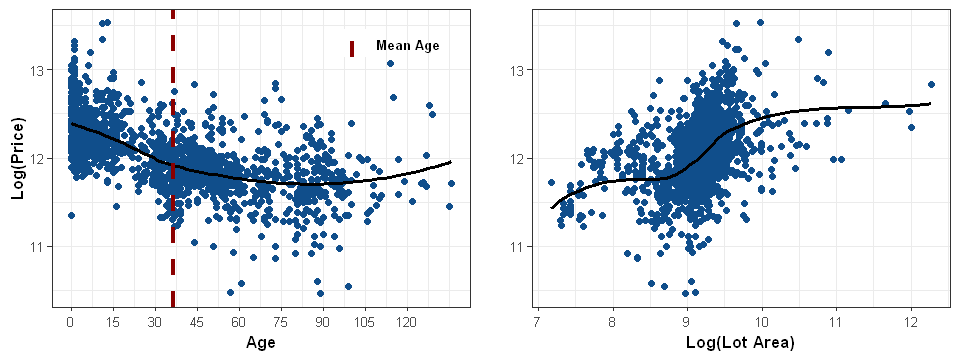

In [87]:
options(repr.plot.width = 8, repr.plot.height = 3)

age_price_plot<-data%>%
    ggplot()+
    geom_point(aes(Age, log_price), color = "dodgerblue4")+
    geom_smooth(aes(Age, log_price), method = "loess", se = F, color = "black")+
    scale_x_continuous(breaks = seq(0, 120, 15))+
    geom_vline(data = data,aes(xintercept = mean(data[,"Age"]), linetype = "Mean Age"),
                               size = 1.3, color = "darkred")+
    scale_linetype_manual(values = c("Mean Age" = "dashed"))+
    labs(x = "Age", y = "Log(Price)")+
    theme_bw()+
    theme(axis.title = element_text(size = 10, face = "bold"),
          axis.text = element_text(size = 8),
          legend.title = element_blank(),
          legend.background = element_blank(),
          legend.text = element_text(size = 8, face = "bold"),legend.position = c(0.80, 0.90))

sqf_price_plot<-data%>%
    ggplot()+
    geom_point(aes(LotArea, log_price), color = "dodgerblue4")+
    geom_smooth(aes(LotArea, log_price), method = "loess", se = F, color = "black")+
    labs(x = "Log(Lot Area)", y = "")+
    theme_bw()+
    theme(axis.title = element_text(size = 10, face = "bold"),
          axis.text = element_text(size = 8))

grid.arrange(age_price_plot, sqf_price_plot, ncol = 2, nrow = 1)

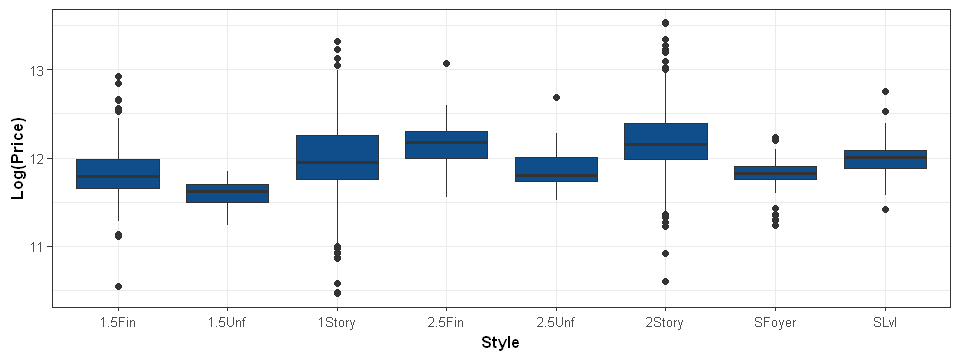

In [16]:
data%>%
    ggplot()+
    geom_boxplot(aes(HouseStyle, log_price), fill = "dodgerblue4")+
    labs(x = "Style", y = "Log(Price)")+
    theme_bw()+
    theme(axis.title = element_text(size = 10, face = "bold"),
          axis.text = element_text(size = 8))

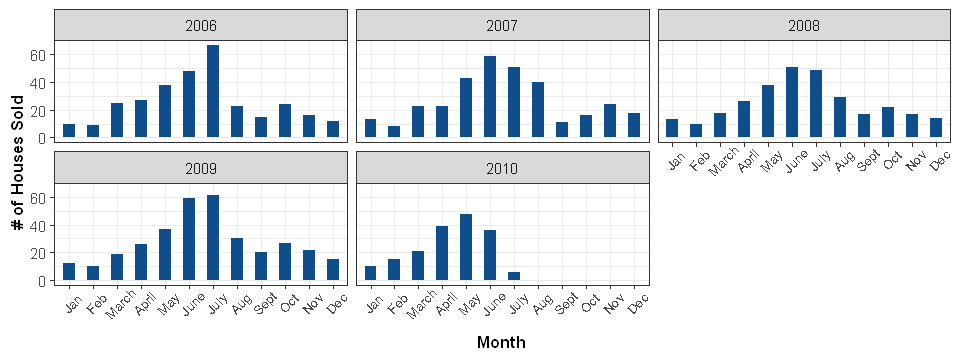

In [55]:
data%>%
    mutate(MoSold = factor(MoSold, 
                    levels = c(1:12), 
                    labels = c("Jan", "Feb", "March", "April", "May", "June", 
                               "July", "Aug", "Sept", "Oct", "Nov", "Dec")))%>%
    ggplot()+
    geom_bar(aes(MoSold), width = 0.5, fill = "dodgerblue4")+
    facet_wrap(~YrSold)+
    labs(x = "Month", y = "# of Houses Sold")+
    theme_bw()+
    theme(axis.title = element_text(size = 10, face = "bold"),
          axis.text.x = element_text(size = 8, vjust = 0.80, angle = 45.0))

### II. Preliminary Models

In [173]:
data["LotArea_c"]<-data[,"LotArea"] - mean(data[,"LotArea"])
data["Age_c"]<-data[,"Age"] - mean(data[,"Age"])

eq<-"log_price ~ LotArea  + Age + I(Age**2) + Bedrooms"
eq2<-"log_price ~ LotArea + I(LotArea_c**2) + I(LotArea_c**3) + Age + I(Age**2)+ Bedrooms"

model_1 = lm(eq, data)
model_2 = lm(eq2, data)

$$\hat{\text{log(price)}} = 9.89 + 0.27\text{log(Lot Area)} - 0.017Age + 0.00010Age^2 + 0.045\text{Three Bedrooms} + 0.21\text{Four Bedrooms}$$

$$\hat{\text{log(price)}} = 9.39 + 0.33\text{log(Lot Area)} + 0.034\text{log(Lot Area)}_{c}^2 - 0.024\text{log(Lot Area)}_{c}^3 - 0.017Age + 0.00010Age^2 + 0.043\text{Three Bedrooms} + 0.20\text{Four Bedrooms}$$